Answer all questions and submit them either as an IPython notebook, LaTeX document, or Markdown document. Each question is worth 25 points.

This homework is due Tuesday, October 24, 2017.

In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pylab as plt
import pandas as pd

# Set seed
np.random.seed(10011)

# Question 1

Epidemiologists are interested in studying the sexual behavior of individuals at risk for HIV infection. Suppose 1500 gay men were surveyed and each was asked how many risky sexual encounters he had in the previous 30 days. Let $n_i$ denote the number of respondents reporting $i$ encounters, for $i = 1, \ldots , 16$. The DataFrame below contains these reponses:

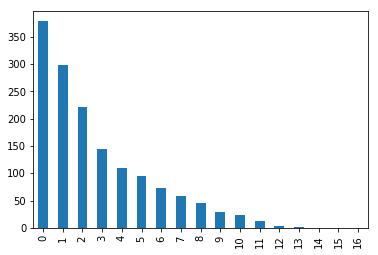

In [6]:
encounters = pd.DataFrame({'count': np.arange(17),
                          'freq': [379, 299, 222, 145, 109, 95, 73, 59,
                                  45, 30, 24, 12, 4, 2, 0, 1, 1]})

encounters.freq.plot.bar()

These data are poorly fitted by a Poisson model. It is more realistic to assume that the respondents comprise three groups. First, there is a group of people who, for whatever reason, report zero risky encounters even if this is not true. Suppose a respondent has probability $\alpha$ of belonging to this group. 

With probability $\beta$, a respondent belongs to a second group representing typical behavior. Such people respond truthfully, and their numbers of risky encounters are assumed to follow a $\text{Poisson}(\mu)$ distribution. 

Finally, with probability $1 − \alpha − \beta$, a respondent belongs to a high-risk group. Such people respond truthfully, and their numbers of risky encounters are assumed to follow a $\text{Poisson}(\lambda)$ distribution. 

The parameters in the model are $\alpha, \beta, \mu$ and $\lambda$. At the tth iteration of EM, we use $\theta^{(t)} = (\alpha^{(t)}, \beta^{(t)}, \mu^{(t)}, \lambda^{(t)})$ to denote the current parameter values. The likelihood of the observed data is given by:

$$L(\theta | n_0, \ldots, n_16) \propto \prod_{i=0}^{16} \left[ \frac{\pi_i(\theta)}{i!} \right]^{n_i}$$

where $\pi_i(\theta) = \alpha 1_{(i=0)} + \beta \mu^i \exp(-\mu) + (1-\alpha - \beta) \lambda^i \exp(-\lambda)$.

The observed data are in the `encounters` table above; the *complete* data may be construed to be $(n_{z,0}, n_{t,0}, n_{p,0}), \ldots, (n_{z,16}, n_{t,16}, n_{p,16})$, where $k = z, t, p$ correspond to zero, typical and promiscuous groups, respectively. That is, $n_0 = n_{z,0} + n_{t,0} + n_{p,0}$, and so on. Let $N = \sum_{i=0}^{16} n_i = 1500$.

Also define:

$$\begin{align}
z_0(\theta) &=& \frac{\alpha}{\pi_0(\theta)} \\
t_i(\theta) &=& \frac{\beta \mu^i \exp(-\mu)}{\pi_i(\theta)} \\
p_i(\theta) &=& \frac{(1-\alpha-\beta)\lambda^i \exp(-\lambda)}{\pi_i(\theta)}
\end{align}$$

which correspond to probabilities that respondents with $i$ risky encounters belong to various groups.

a. Show that the EM algorithm provides the following updates:

$$\begin{align}
\alpha^{(t+1)} &=& \frac{n_0 z_0(\theta^{(t)})}{N} \\
\beta^{(t+1)} &=& \sum_i \frac{n_i t_i(\theta^{(t)})}{N} \\
\mu^{(t+1)} &=& \frac{\sum_i i n_i t_i(\theta^{(t)})}{\sum_i n_i t_i(\theta^{(t)})} \\
\lambda^{(t+1)} &=& \frac{\sum_i i n_i p_i(\theta^{(t)})}{\sum_i n_i p_i(\theta^{(t)})}
\end{align}$$


b. Extimate the parameters of the model using the observed data.

In [3]:
# Write your answer here

In [7]:
from scipy.stats.distributions import poisson


def e_step(alpha,beta,mu,lam):
    t=[]
    p=[]
    
    
    for i in range(0,16+1):
        pi=alpha*(i==0)+beta*np.exp(-mu)*(mu**i) +(1-alpha-beta)*(lam**i)*np.exp(-lam)
        p0=alpha+beta*np.exp(-mu)+(1-alpha-beta)*np.exp(-lam)
        z= alpha/p0
        ti=beta*(mu**i)*np.exp(-mu)/pi
        t.append(ti)
        
        pt=(1-alpha-beta)*(lam**i)*np.exp(-lam)/pi
        p.append(pt)
    
    return z,t,p

def m_step(z,t,p,n,N=1500):
    #n is a vector of n0,n1,...,n16
    # w is the combination of z,t,p from e step
    
    
    t=np.array(t)
    p=np.array(p)
    
    alpha= n[0]*z/N
    beta=np.sum(n*t/N)
    
    tsum=0
    for i in range(0,16+1):
        tsum=tsum+i*n[i]*t[i]
        
    mu=tsum/np.sum(n*t)
    
    psum=0
    for i in range(0,16+1):
        psum=psum+i*p[i]*n[i]
    
    lam=psum/np.sum(n*p)
    
    return alpha,beta,mu,lam


resp=np.array([379, 299, 222, 145, 109, 95, 73, 59,45, 30, 24, 12, 4, 2, 0, 1, 1]) #data
    

def run_em(alpha0=0.7, beta0=0.2,mu0=6,lam0=5, n=resp):
    
    # Initialize values
    alpha=alpha0
    beta=beta0
    mu=mu0
    lam=lam0

    # Stopping criterion
    crit = 1e-5

    # Convergence flag
    converged = False

    # Loop until converged
    while not converged:

        # E-step
        z,t,p = e_step(alpha,beta,mu,lam)
        # M-step
        alpha_new, beta_new,mu_new,lam_new = m_step(z,t,p,n)

        # Check convergence
        converged = ( np.all(np.abs((np.array(alpha_new) - np.array(alpha)) < crit)) 
                     & np.all(np.abs((np.array(mu_new) - np.array(mu)) < crit))
                     & np.all(np.abs((np.array(beta_new) - np.array(beta)) < crit))
                     & np.all(np.abs((np.array(lam_new) - np.array(lam)) < crit)) ) 
                
        alpha, beta, mu, lam = alpha_new, beta_new,mu_new,lam_new

    return  alpha, beta, mu, lam

run_em() #the estimates

(0.12226721879723244,
 0.31518990779513451,
 5.9396763179050804,
 1.4681084910449191)

In [26]:
a,b,c=e_step(1,2,3,4)

In [15]:
a

-0.0

In [18]:
len(b)

17

In [27]:
n=np.array([379, 299, 222, 145, 109, 95, 73, 59,45, 30, 24, 12, 4, 2, 0, 1, 1])

In [22]:
type(n)

list

In [28]:
b=np.array(b)

In [ ]:
print(np.sum(n*b))

In [4]:
def m_step(z,t,p,n,N=1500):
    #n is a vector of n0,n1,...,n16
    # w is the combination of z,t,p from e step
    
    
    t=np.array(t)
    p=np.array(p)
    
    alpha= n[0]*z/N
    beta=np.sum(n*t/N)
    
    tsum=0
    for i in range(0,16+1):
        tsum=tsum+i*n[i]*t[i]
        
    mu=tsum/np.sum(n*t)
    
    psum=0
    for i in range(0,16+1):
        psum=psum+i*p[i]*n[i]
    
    lam=psum/np.sum(n*t)
    
    return alpha,beta,mu,lam


In [35]:
m_step(a,b,c)

(-0.0, 0.94747634992871843, 0.56861375574705153, 2.2789507245726726)

In [8]:
resp=np.array([379, 299, 222, 145, 109, 95, 73, 59,45, 30, 24, 12, 4, 2, 0, 1, 1]) #data
    

def run_em(alpha0=0.2, beta0=0.5,mu0=5,lam0=5, n=resp):
    
    # Initialize values
    alpha=alpha0
    beta=beta0
    mu=mu0
    lam=lam0

    # Stopping criterion
    crit = 1e-5

    # Convergence flag
    converged = False

    # Loop until converged
    while not converged:

        # E-step
        z,t,p = e_step(alpha,beta,mu,lam)
        # M-step
        alpha_new, beta_new,mu_new,lam_new = m_step(z,t,p,n)

        # Check convergence
        converged = ( np.all(np.abs((np.array(alpha_new) - np.array(alpha)) < crit)) 
                     & np.all(np.abs((np.array(mu_new) - np.array(mu)) < crit))
                     & np.all(np.abs((np.array(beta_new) - np.array(beta)) < crit))
                     & np.all(np.abs((np.array(lam_new) - np.array(lam)) < crit)) ) 
                
        alpha, beta, mu, lam = alpha_new, beta_new,mu_new,lam_new

    return  alpha, beta, mu, lam

In [9]:
run_em(alpha0=0.6)

(0.0, -4.2560460885945739, 0.55559594525599321, -1.189517651891207)

In [7]:
list(range(0,17))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

# Question 2

Suppose $y$ has a binomial distribution with parameters $n$ and $p$, and we are interested in the log-odds value $\theta = \log(p/(1 − p))$. Our prior for $\theta$ is that $\theta \sim N(\mu, \sigma^2)$. It follows that the posterior density of $\theta$ is given, up to a proportionality constant, by:

$$\pi(\theta | y) \propto \frac{\exp(y\theta)}{(1 + exp(\theta))^n} \exp\left[\frac{-(\theta − \mu)^2}{2\sigma^2}\right]$$

For example, suppose we are interested in learning about the probability that a possibly-biased coin lands heads when tossed. *A priori* we believe that the coin is fair, so we assign $\theta$ a $N(0,.25)$ prior. We toss the coin $n = 5$ times and obtain $y = 5$ heads.

1. Using a normal approximation to the posterior density, compute the probability that the coin is biased toward heads (i.e., that θ is positive).
2. Using the prior density as a proposal density, design a rejection algorithm for sampling from the posterior distribution. Using simulated draws from your algorithm, approximate the probability that the coin is biased toward heads.
3. Using the prior density as a proposal density, simulate values from the posterior distribution using the SIR algorithm. Approximate the probability that the coin is biased toward heads.

## 1. Using a normal approximation to the posterior density, compute the probability that the coin is biased toward heads (i.e., that θ is positive).

In [3]:
# Write your anser here
#1. normal approximation
import scipy as sp
import scipy.stats as stats

binom=stats.binom
norm=stats.norm

def post_norm(theta,n=5,y=5): #log of post probability
    post=(y*theta)-np.log((1+np.exp(theta))**n) -(theta**2)/(2*0.25)
    return post

from scipy.optimize import minimize

post_min = lambda *args: -post_norm(*args)

#logarithm of the unnormalized joint posterior:approximating the density as normal.

init_value = 0.5 

opt = minimize(post_min, init_value, method='L-BFGS-B')
mode = opt.x
var = opt.hess_inv.todense() 
mode, var # mode and variance to returns the kernel of a normal distribution 



(array([ 0.47831304]), array([[ 0.19312189]]))

In [ ]:
#compute the probability that the coin is biased toward heads (i.e., that θ is positive).
1-norm.cdf(0,loc=mode,scale=np.sqrt(var))

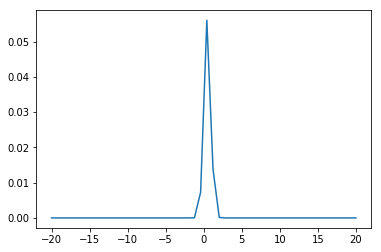

In [46]:
x=np.linspace(-20,20)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.plot(x, np.exp(post_norm(x)))

In [47]:
np.exp(post_norm(-3))

3.6540627729200116e-15

In [7]:
from scipy.optimize import minimize

post_min = lambda *args: -post_norm(*args)

#logarithm of the unnormalized joint posterior:approximating the density as normal.

init_value = 0.5 

opt = minimize(post_min, init_value, method='L-BFGS-B')
mode = opt.x
var = opt.hess_inv.todense() 
mode, var # mode and variance to returns the kernel of a normal distribution 

NameError: name 'np' is not defined

In [65]:
opt

      fun: array([ 2.869167])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -5.77315973e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 2
   status: 0
  success: True
        x: array([ 0.47831304])

In [50]:
det = np.linalg.det #determinant of array 
inv = np.linalg.inv #inverse of matrix

def lmvn(value, mu, Sigma):#post prob
    delta = value - mu
    return  -0.5 * (np.log(det(Sigma)) + np.dot(delta, np.dot(inv(Sigma), delta)))

In [94]:
norm.pdf(5,loc=mode,scale=np.sqrt(var))

array([[  9.30673722e-24]])

In [79]:
1-norm.cdf(0,loc=mode,scale=np.sqrt(var)) #compute the probability that the coin is biased toward heads (i.e., that θ is positive).

array([[ 0.86179511]])

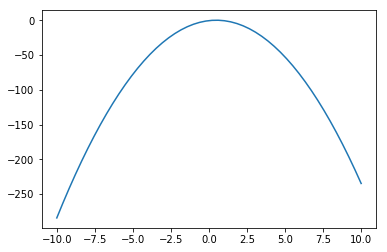

In [60]:
k_x = np.linspace(-10, 10)

z = np.array([lmvn(t1,mode,var) 
               for t1 in k_x ] )

import matplotlib.pyplot as plt #show the plot of h(theta)-h(theta_mle)
fig, ax = plt.subplots(1, 1)
ax.plot(k_x, z-z.max())           

In [95]:

np.exp(lmvn(5,mode,var)-z.max() )


1.0739212252233608e-23

ValueError: x and y must have same first dimension, but have shapes (50,) and (1, 50)

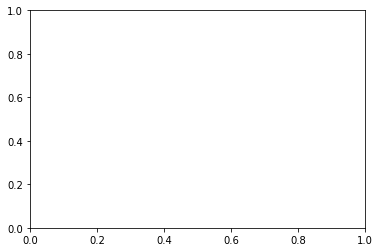

In [64]:
fig, ax = plt.subplots(1, 1)
ax.plot(k_x, norm.cdf(k_x,mode,var))

In [28]:
post_norm(1)

-3.5663084375911138

In [26]:
np.exp(post_norm(mode))

array([ 0.05674618])

In [32]:
lmvn(3,mode,var) 

1.6110119884663382e-07

## 2.Using the prior density as a proposal density, design a rejection algorithm for sampling from the posterior distribution. Using simulated draws from your algorithm, approximate the probability that the coin is biased toward heads.

In [ ]:
#sample  g(x),  accept or reject each of these values based upon  f(xi)
#draw a uniform random variate ui
#for each draw  accept  xi  if  ui<f(xi)/cg(xi), where  c  is a constant


In [4]:
def post_norm(theta,n=5,y=5): #log of post probability
    post=(y*theta)-np.log((1+np.exp(theta))**n) -(theta**2)/(2*0.25)
    return post

def calc_diff(theta):
    
    return post_norm(theta) - norm.logpdf(theta, 0, 0.5)

calc_diff_min = lambda *args: -calc_diff(*args)

c=opt.fun #find c to use

def reject(n,  c):
    
    # Draw samples from g(theta)
    theta = norm.rvs(0, 0.5, size=n)
    
    # Calculate probability under g(theta)
    gvals = np.array([norm.logpdf(t,0,0.5) for t in theta])

    # Calculate probability under f(theta)
    fvals = np.array([post_norm(t) for t in theta ])
    
    # Calculate acceptance probability
    p = np.exp(fvals - gvals + c)
    
    return theta[np.random.random(n) < p]
    #return p,theta,fvals,gvals
    
nsamples = 15000
sample = reject(nsamples,  c)
sum(sample>0)/(sample.size) #from accepted samples, what proportion >0

0.76296217594560134

In [89]:
np.exp(post_norm(0)-norm.logpdf(0,0,0.5)-0.22)

0.031431504842119234

In [84]:
post_norm(0)

-3.4657359027997265

In [94]:
from scipy.optimize import minimize
opt = minimize(calc_diff_min, 
               -3, 
                method='bfgs')

In [83]:
calc_diff(-4)

-19.864958286944322

In [95]:
opt

      fun: -0.22578268286588354
 hess_inv: array([[ 36795.80102572]])
      jac: array([ -7.62939453e-06])
  message: 'Optimization terminated successfully.'
     nfev: 57
      nit: 17
     njev: 19
   status: 0
  success: True
        x: array([ 13.26510432])

In [96]:
c=opt.fun

In [97]:
def reject(n,  c):
    
    # Draw samples from g(theta)
    theta = norm.rvs(0, 0.5, size=n)
    
    # Calculate probability under g(theta)
    gvals = np.array([norm.logpdf(t,0,0.5) for t in theta])

    # Calculate probability under f(theta)
    fvals = np.array([post_norm(t) for t in theta ])
    
    # Calculate acceptance probability
    p = np.exp(fvals - gvals + c)
    
    return theta[np.random.random(n) < p]
    #return p,theta,fvals,gvals

In [103]:
nsamples = 15000
sample = reject(nsamples,  c)
sum(sample>0)/(sample.size) #from accepted samples, what proportion >0


0.85350318471337583

In [101]:
sum(sample>0)/(sample.size)

0.86293436293436299

In [67]:
p,theta,fv,gv=sample

In [59]:
gv.shape

(1000,)

In [72]:
theta

array([ -5.91022886e-01,  -3.35050609e-01,   4.73844434e-01,
        -7.92442197e-02,  -9.04182700e-02,   3.85583336e-01,
         5.66141272e-01,  -1.02955662e+00,  -3.32755165e-02,
        -1.29042917e-01,  -2.51582133e-01,  -1.53568589e-01,
         2.26296353e-01,   6.41343374e-01,   2.49823977e-01,
        -1.19222597e-01,   6.32323198e-01,  -5.61262634e-01,
         1.68971538e-01,  -5.15850280e-01,  -3.91709995e-01,
         1.80249423e-01,  -5.68079468e-01,  -5.55295715e-01,
         9.16318941e-01,  -2.31171667e-02,   6.82266392e-01,
         6.78293624e-01,  -1.60546829e-01,   5.25949116e-01,
         2.69163344e-01,  -5.78780141e-03,  -6.35933908e-01,
        -5.26003211e-02,  -6.60201294e-01,  -2.04963119e-01,
        -2.44053567e-01,   1.49885016e-01,  -1.83038868e-01,
         5.95927487e-01,   5.82048797e-01,   5.07317567e-01,
        -9.85142407e-02,   9.19148609e-02,  -1.07490744e+00,
         5.03850441e-02,   2.39862790e-01,   3.51491059e-01,
         1.42502437e-02,

In [61]:
fv.shape

(1000,)

## 3. Using the prior density as a proposal density, simulate values from the posterior distribution using the SIR algorithm. Approximate the probability that the coin is biased toward heads.

In [59]:
n=20000
theta = norm.rvs(0, 0.5, size=n)
    
# Calculate probability under q(theta)-prior
q_theta = np.array([norm.logpdf(t,0,0.5) for t in theta])

# Calculate probability under f(theta)-posterior
f_theta = np.array([post_norm(t) for t in theta ])
    
w = np.exp(f_theta - q_theta - max(f_theta - q_theta)) #normalize

p_sir = w/w.sum()

theta_sir = theta[np.random.choice(range(len(theta)), size=10000, p=p_sir)]

logK_sample = theta_sir[:,]
logK_sample.sort()
#probability of theta larger than 0
sum(logK_sample>0)/10000

0.86629999999999996

# Question 3

The goal of this problem is to investigate the role of the proposal distribution in a Metropolis-Hastings algorithm designed to simulate from the posterior distribution of the mixture parameter $\delta$. 

1. Simulate 200 realizations from the mixture distribution:
    $$y_i \sim \delta N(7, 0.5^2) + (1-\delta) N(10, 0.5^2)$$
    with $\delta = 0.7$. Plot a histogram of these data. 
2. Implement a random walk M-H algorithm with proposal $\delta^{\prime} = \delta^{(i)} + \epsilon$ with $\epsilon \sim Unif(−1,1)$. 
3. Reparameterize the problem letting $U = \log\left[\frac{\delta}{1 - \delta}\right]$ and $u^{\prime} = u^{(i)} + \epsilon$. Implement a random walk chain in U-space. 
4. Compare the estimates and convergence behavior of the three algorithms.

In part (1), you are asked to simulate data from a distribution with $\delta$ known. For parts (2)–(3), assume $\delta$ is unknown with prior $\delta \sim Unif( 0,1)$. For parts (2)–(3), provide an appropriate plot and a table summarizing the output of the algorithm. 

To facilitate comparisons, use the same number of iterations, random seed, starting values, and burn-in period for all implementations of the algorithm. 

In [8]:
# Write answer here
#1. generate 200 realizations
from scipy.stats import norm

n=200
n1=norm.rvs(loc=7,scale=0.5,size=n)
n2=norm.rvs(loc=10,scale=0.5,size=n)
sigma=0.7
pop=n1*sigma+n2*(1-sigma)

(array([  4.,  17.,  19.,  40.,  36.,  42.,  27.,   7.,   6.,   2.]),
 array([ 7.04416853,  7.2310282 ,  7.41788787,  7.60474753,  7.7916072 ,
         7.97846686,  8.16532653,  8.35218619,  8.53904586,  8.72590552,
         8.91276519]),
 <a list of 10 Patch objects>)

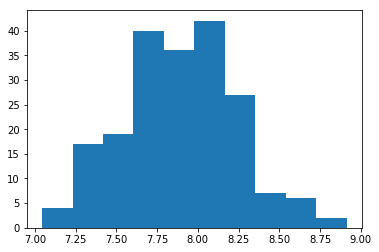

In [9]:
fig, ax = plt.subplots(1, 1)
ax.hist(pop)

In [6]:
pop.shape

(200,)

In [12]:
from scipy.stats import uniform,norm
dnorm=norm.logpdf
dunif=uniform.logpdf

In [5]:
def calc_posterior(t,d,y=pop):
    logp = np.log(1)+np.log(1/2)
    logp += sum( np.log( d* norm.pdf(y,7,0.5) + (1-d)*norm.pdf(y,10,0.5) ) )
    
    return logp

In [7]:
calc_posterior(0.1,0.1)

-810.53494370715794

In [13]:
dunif(0,-1,2)

-0.69314718055994529

In [ ]:
uniform()

## 2. Implement a random walk M-H algorithm with proposal  δ′=δ(i)+ϵ  with  ϵ∼Unif(−1,1)

In [13]:
#2. Implement a random walk M-H algorithm with proposal  δ′=δ(i)+ϵ  with  ϵ∼Unif(−1,1)

def calc_posterior(d,y=pop):
    logp = np.log(1)
    logp += sum( np.log( d* norm.pdf(y,7,0.5) + (1-d)*norm.pdf(y,10,0.5) ) )
    
    return logp

def metropolis(n_iterations, initial_values):

    n_params = 1
            
    # Initial proposal standard deviations
    #prop_sd = [prop_var]*n_params
    
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
    trace[0] = initial_values
        
    # Calculate joint posterior for initial values, trace is a 1 parameter list
    current_log_prob = calc_posterior(trace[0])
    
    # Initialize acceptance counts, start with [0,0]
    accepted = [0]*n_params
    
    for i in range(n_iterations):
    
        if not i%1000: print('Iteration %i' % i) # every 1000, print sth
    
        # Grab current parameter values
        current_params = trace[i]
    
        for j in range(n_params):
    
            # Get current value for parameter j
            p = trace[i].copy()
    
            # Propose new value
            
            p = current_params+uniform.rvs(loc=-1,scale=2,size=1)
            
        
            # Calculate log posterior with proposed value
            proposed_log_prob = calc_posterior(p)
    
            # Log-acceptance rate
            alpha = proposed_log_prob - current_log_prob
    
            # Sample a uniform random variate
            u = runif()
    
            # Test proposed value
            if np.log(u) < alpha:
                # Accept
                trace[i+1] = p
                current_log_prob = proposed_log_prob
                accepted[j] += 1
            else:
                # Reject
                trace[i+1] = trace[i]
                
                
    return trace, accepted



In [14]:
tr, acc = metropolis(10000, 0.7)

Iteration 0


NameError: name 'runif' is not defined

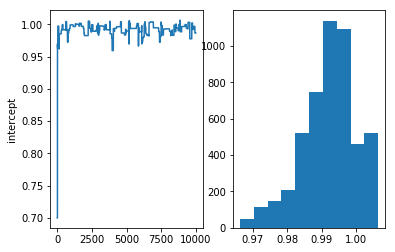

In [63]:
#plot
for param, samples in zip(['intercept', 'slope'], tr.T):
    fig, axes = plt.subplots(1, 2)
    axes[0].plot(samples)
    axes[0].set_ylabel(param)
    axes[1].hist(samples[int(len(samples)/2):])


In [62]:
#acceptance rate
np.array(acc, float)/10000

array([ 0.0134])

## 3. Reparameterize the problem letting  U=log[δ/1−δ]  and  u′=u(i)+ϵ Implement a random walk chain in U-space


In [68]:

#d=exp(u)/1+exp(u)


def calc_posterior(u,y=pop):
    
    d=np.exp(u)/(1+np.exp(u)) #convert u to d 
    logp= np.log(1) #prior
    logp += sum( np.log( d* norm.pdf(y,7,0.5) + (1-d)*norm.pdf(y,10,0.5) ) ) #posterior
    
    return logp

def metropolisuspace(n_iterations, initial_values,prop_var=1):

    n_params = 1
            
    # Initial proposal standard deviations
    prop_sd = [prop_var]*n_params
    
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
    trace[0] = initial_values
        
    # Calculate joint posterior for initial values, trace is a 2 parameter list-use * to unravel
    current_log_prob = calc_posterior(trace[0])
    
    # Initialize acceptance counts, start with [0,0]
    accepted = [0]*n_params
    
    for i in range(n_iterations):
    
        if not i%1000: print('Iteration %i' % i) # every 1000, print sth
    
        # Grab current parameter values
        current_params = trace[i]
    
        for j in range(n_params):
    
            # Get current value for parameter j
            p = trace[i].copy()
    
            # Propose new value
            theta = np.exp(rnorm(np.log(current_params), prop_sd))
            
            p = theta

            # Calculate log posterior with proposed value
            proposed_log_prob = calc_posterior(p)
    
            # Log-acceptance rate
            alpha = proposed_log_prob - current_log_prob
    
            # Sample a uniform random variate
            u = runif()
    
            # Test proposed value
            if np.log(u) < alpha:
                # Accept
                trace[i+1] = p
                current_log_prob = proposed_log_prob
                accepted[j] += 1
            else:
                # Reject
                trace[i+1] = trace[i]
                
                
    return trace, accepted



In [86]:
tr, acc = metropolisuspace(10000, 0.7,5)

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000


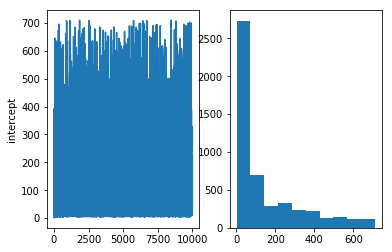

In [87]:
#plot
for param, samples in zip(['intercept', 'slope'], tr.T):
    fig, axes = plt.subplots(1, 2)
    axes[0].plot(samples)
    axes[0].set_ylabel(param)
    axes[1].hist(samples[int(len(samples)/2):])

In [88]:
#acceptance rate
np.array(acc, float)/10000

array([ 0.372])

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
Iteration 10000
Iteration 11000
Iteration 12000
Iteration 13000
Iteration 14000
Iteration 15000
Iteration 16000
Iteration 17000
Iteration 18000
Iteration 19000
Iteration 20000
Iteration 21000
Iteration 22000
Iteration 23000
Iteration 24000
Iteration 25000
Iteration 26000
Iteration 27000
Iteration 28000
Iteration 29000


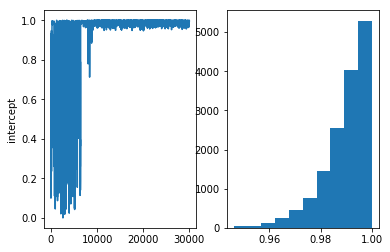

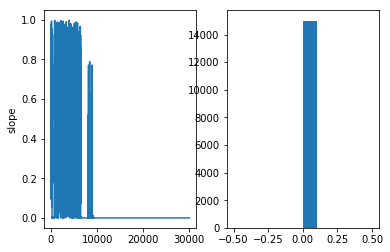

In [16]:
rnorm = np.random.normal
runif = np.random.uniform

def metropolis(n_iterations, initial_values, prop_var=1,
                     tune_for=None, tune_interval=100):

    n_params = len(initial_values)

    # Initial proposal standard deviations
    prop_sd = [prop_var] * n_params

    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))

    # Set initial values
    trace[0] = initial_values
    # Initialize acceptance counts
    accepted = [0]*n_params

    # Calculate joint posterior for initial values
    current_log_prob = calc_posterior(*trace[0])

    if tune_for is None:
        tune_for = n_iterations/2

    for i in range(n_iterations):

        if not i%1000: print('Iteration', i)

        # Grab current parameter values
        current_params = trace[i]

        for j in range(n_params):

            # Get current value for parameter j
            p = trace[i].copy()

            # Propose new value
            if j==1:
                # Ensure d is >0
                theta = np.exp(rnorm(np.log(current_params[j]), prop_sd[j]))
                #theta = abs(rnorm(current_params[j], prop_sd[j]))
                    
            else: #for t: just normal
                theta = rnorm(current_params[j], prop_sd[j])
            

            # Insert new value
            p[j] = theta

            # Calculate log posterior with proposed value
            proposed_log_prob = calc_posterior(*p)

            # Log-acceptance rate
            alpha = proposed_log_prob - current_log_prob

            # Sample a uniform random variate
            u = runif()

            # Test proposed value
            if np.log(u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_log_prob = proposed_log_prob
                accepted[j] += 1
            else:
                # Reject
                trace[i+1,j] = trace[i,j]

            # Tune every 100 iterations
            if (not (i+1) % tune_interval) and (i < tune_for):

                # Calculate aceptance rate
                acceptance_rate = (1.*accepted[j])/tune_interval
                if acceptance_rate<0.2:
                    prop_sd[j] *= 0.9
                elif acceptance_rate>0.5:
                    prop_sd[j] *= 1.1

                accepted[j] = 0

    return trace, accepted

# Run MCMC
tr, acc = metropolis(30000, (0.1,0.5))

for param, samples in zip(['intercept', 'slope'], tr.T):
    fig, axes = plt.subplots(1, 2)
    axes[0].plot(samples)
    axes[0].set_ylabel(param)
    axes[1].hist(samples[int(len(samples)/2):])




In [36]:
a,b=tr.T

In [17]:
np.array(acc, float)/30000

array([ 0.15056667,  0.41673333])

In [37]:
a[29990:]

array([-0.3288861 , -0.3288861 ,  0.65204582, -0.25566649, -0.25566649,
       -0.02934198,  0.50341378,  0.50341378,  0.50341378,  0.50341378,
        0.66483832])

In [39]:
b[20000:]

array([ 0.98770699,  0.98770699,  0.98770699, ...,  0.99193988,
        0.99193988,  0.99193988])

In [38]:
len((1,1))

2

In [72]:
n_iter = 10000
trace, acc = metropolis(n_iter, (1,1), 0.005)

Iteration 0


/Users/ying/anaconda2/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000


In [69]:
np.array(acc, float)/n_iter

array([ 0.,  0.])

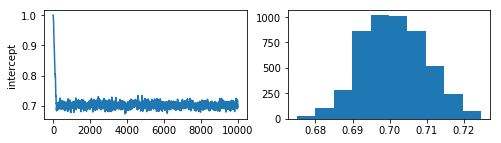

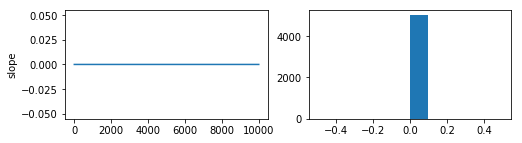

In [20]:
for param, samples in zip(['intercept', 'slope','precision'], trace.T):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    axes[0].plot(samples)
    axes[0].set_ylabel(param)
    axes[1].hist(samples[int(n_iter/2):])

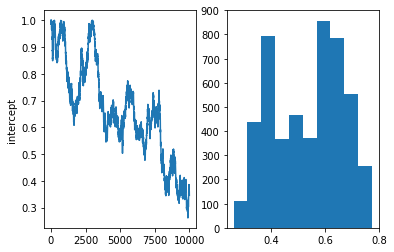

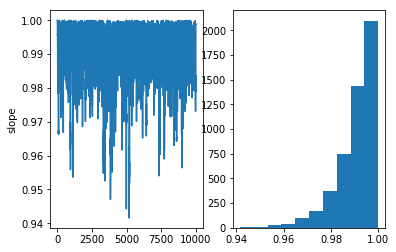

In [65]:


for param, samples in zip(['intercept', 'slope'], trace.T):
    fig, axes = plt.subplots(1, 2)
    axes[0].plot(samples)
    axes[0].set_ylabel(param)
    axes[1].hist(samples[len(samples)//2:])

#a, b = tr.T
#print('LD50 mean is {}'.format(ld50(a,b).mean()))

In [28]:
n_iter

10000

In [30]:
trace_tuned,acc = metropolis_tuned(n_iter, (1,0))

Iteration 0


IndexError: list assignment index out of range

In [ ]:
#3 Reparameterize the problem letting  U=log[δ1−δ]U=log⁡[δ1−δ]  and  u′=u(i)+ϵu′=u(i)+ϵ . Implement a random walk chain in U-space.

In [119]:
np.empty((1,2))

array([[  3.00604243e-11,  -9.61386085e-14]])

## 4 Compare the estimates and convergence behavior of the three algorithms.

# Question 4

Carlin (1992) considers a Bayesian approach to meta-analysis, and includes the following examples of 22 trials of beta-blockers to prevent mortality after myocardial infarction. These data are given below.

In one possible random effects model we assume the true baseline mean (on a log-odds scale) $m_i$ in a trial $i$
is drawn from some population distribution. Let $r^C_i$ denote number of events in the control group in trial $i$, and $r^T_i$ denote events under active treatment in trial $i$. Our model is:

$$\begin{aligned}
r^C_i &\sim \text{Binomial}\left(p^C_i, n^C_i\right) \\
r^T_i &\sim \text{Binomial}\left(p^T_i, n^T_i\right) \\
\text{logit}\left(p^C_i\right) &= \mu_i \\
\text{logit}\left(p^T_i\right) &= \mu_i + \delta \\
\mu_i &\sim \text{Normal}(m, s).
\end{aligned}$$

In this case, we want to make inferences about the population effect $m$, and the predictive distribution for the effect $\delta_{\text{new}}$ in a new trial. 

This particular model uses a random effect for the population mean, and a fixed effect for the treatment effect. There are 3 other models you could fit to represent all possible combinations of fixed or random effects for these two parameters.

Build all 4 models to estimate the treatment effect in PyMC3 and 

1. use convergence diagnostics to check for convergence in each model 
2. use posterior predictive checks to compare the fit of the models
3. use DIC to compare the models as approximations of the true generating model

Which model would you select and why?

In [15]:
r_t_obs = [3, 7, 5, 102, 28, 4, 98, 60, 25, 138, 64, 45, 9, 57, 25, 33, 28, 8, 6, 32, 27, 22]
n_t_obs = [38, 114, 69, 1533, 355, 59, 945, 632, 278,1916, 873, 263, 291, 858, 154, 207, 251, 151, 174, 209, 391, 680]
r_c_obs = [3, 14, 11, 127, 27, 6, 152, 48, 37, 188, 52, 47, 16, 45, 31, 38, 12, 6, 3, 40, 43, 39]
n_c_obs = [39, 116, 93, 1520, 365, 52, 939, 471, 282, 1921, 583, 266, 293, 883, 147, 213, 122, 154, 134, 218, 364, 674]
N = len(n_c_obs)

In [16]:
from pymc3 import traceplot
from pymc3 import summary

# build 4 models

In [28]:
# model 1: random effect for the population mean, and a fixed effect for the treatment effect.
from pymc3 import Normal, Binomial, sample, HalfCauchy, Model, Cauchy
from pymc3.math import invlogit


with pm.Model() as meta:
    
    #prior-random population mean
    m=Normal("m",0,sd=1e5)
    s=HalfCauchy('s', 5)
    
    mu=Normal("mu",m,sd=s) 
    
    #fixed delta
    delta= Cauchy('delta',0,5) 
    
    pc=pm.invlogit(mu)
    pt=pm.invlogit(mu+delta)
    
  
    # Data likelihood
    obs_rt = Binomial('obs_rt', n=n_t_obs, p=pt, observed=r_t_obs)
    obs_rc = Binomial('obs_rc', n=n_c_obs, p=pc, observed=r_c_obs)
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 3989/4000 [00:15<00:00, 375.33it/s]/Users/ying/anaconda2/envs/bios8366/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.718380957123, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/ying/anaconda2/envs/bios8366/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 240 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 4000/4000 [00:16<00:00, 249.72it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11af905f8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11cbf9898>]], dtype=object)

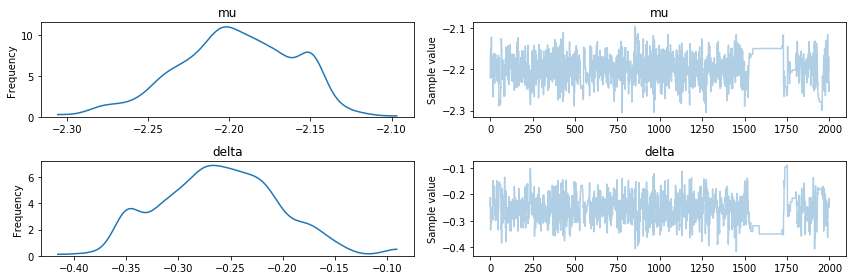

In [29]:
with meta:
    trace1=sample(2000,tune=2000)
    
#plot
%matplotlib inline
pm.traceplot(trace1,varnames=['mu','delta'])

#summary(trace) written summary

In [30]:
# model 2: fixed effect for the population mean, and a fixed effect for the treatment effect.
from pymc3 import Normal, Binomial, sample, HalfCauchy, Model, Cauchy
from pymc3.math import invlogit


with pm.Model() as metaf:
    
    #fixed-random population mean
    
    mu=Normal("mu",0,1e5) 
    
    #fixed delta
    delta= Cauchy('delta',0,5) 
    
    pc=pm.invlogit(mu)
    pt=pm.invlogit(mu+delta)
    
  
    # Data likelihood
    obs_rt = Binomial('obs_rt', n=n_t_obs, p=pt, observed=r_t_obs)
    obs_rc = Binomial('obs_rc', n=n_c_obs, p=pc, observed=r_c_obs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 4000/4000 [00:05<00:00, 781.30it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ce4eef0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11cae49b0>]], dtype=object)

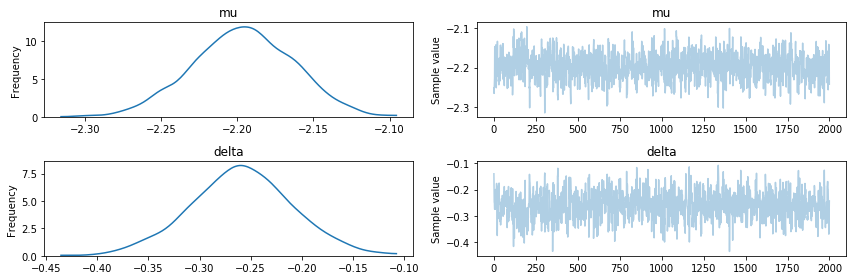

In [31]:
with metaf:
    trace2=sample(2000,tune=2000)
    
#plot
%matplotlib inline
pm.traceplot(trace2,varnames=['mu','delta'])

#summary(trace) 

In [33]:
# model 3: fixed effect for the population mean, and a random effect for the treatment effect.
from pymc3 import Normal, Binomial, sample, HalfCauchy, Model
from pymc3.math import invlogit


with pm.Model() as metard:
    
    #prior-fixed pop mean
    mu=Normal("mu",0,1e5) 
    
    #random delta
    k=Normal("k",0,sd=100)
    q=HalfCauchy('q', 5)
    
    delta= Normal('delta',k,q) 
    
    pc=pm.invlogit(mu)
    pt=pm.invlogit(mu+delta)
    
  
    # Data likelihood
    obs_rt = Binomial('obs_rt', n=n_t_obs, p=pt, observed=r_t_obs)
    obs_rc = Binomial('obs_rc', n=n_c_obs, p=pc, observed=r_c_obs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 99%|█████████▉| 3971/4000 [00:13<00:00, 378.62it/s]/Users/ying/anaconda2/envs/bios8366/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.719907650142, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/ying/anaconda2/envs/bios8366/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 194 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 4000/4000 [00:13<00:00, 300.00it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d58ce10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11cdc44a8>]], dtype=object)

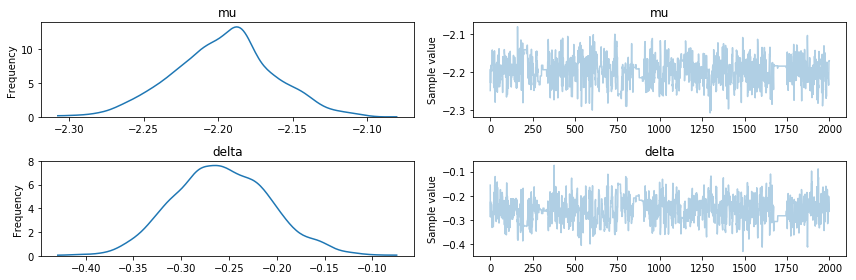

In [34]:
with metard:
    trace3=sample(2000,tune=2000)
    
#plot
%matplotlib inline
pm.traceplot(trace3,varnames=['mu','delta'])

#summary(trace)

In [35]:
# model 4: random effect for the population mean, and a random effect for the treatment effect.
from pymc3 import Normal, Binomial, sample, HalfCauchy, Model
from pymc3.math import invlogit


with pm.Model() as metar:
    
    #prior-random pop mean
     
    m=Normal("m",0,sd=1e5)
    s=HalfCauchy('s', 5)
    
    mu=Normal("mu",m,sd=s) 
    
    #random delta
    k=Normal("k",0,sd=100)
    q=HalfCauchy('q', 5)
    
    delta= Normal('delta',k,q) 
    
    pc=pm.invlogit(mu)
    pt=pm.invlogit(mu+delta)
    
  
    # Data likelihood
    obs_rt = Binomial('obs_rt', n=n_t_obs, p=pt, observed=r_t_obs)
    obs_rc = Binomial('obs_rc', n=n_c_obs, p=pc, observed=r_c_obs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 99%|█████████▉| 3971/4000 [00:22<00:00, 186.65it/s]/Users/ying/anaconda2/envs/bios8366/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.53013624386, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/ying/anaconda2/envs/bios8366/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 426 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 4000/4000 [00:23<00:00, 173.47it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e3dfdd8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11e4f9a58>]], dtype=object)

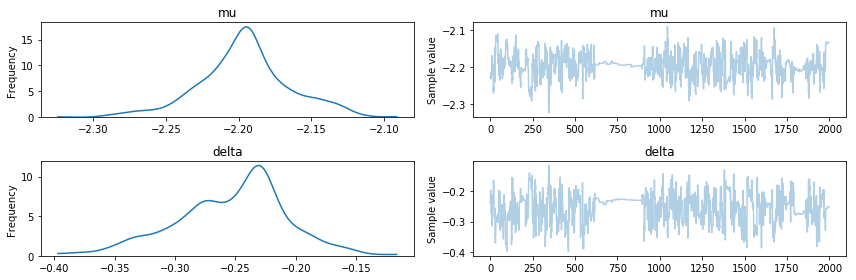

In [36]:
with metar:
    trace4=sample(2000,tune=2000)
    
#plot
%matplotlib inline
pm.traceplot(trace4, varnames=['mu','delta'])

#summary(trace)

# 1. use convergence diagnostics to check for convergence in each model

In [37]:
from pymc3 import geweke

z_rm = geweke(trace1, intervals=15)
z_fix=geweke(trace2,intervals=15)
z_rd=geweke(trace3,intervals=15)
z_r=geweke(trace3,intervals=15)

(0, 1000)

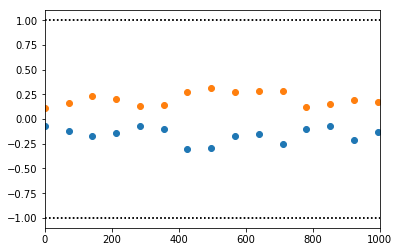

In [38]:
#use geweke 
#Plotting the output displays the scores in series, 
#making it is easy to see departures from the standard normal assumption.
#model 1: random mean 
plt.scatter(*z_rm['mu'].T)
plt.hlines([-1,1], 0, 1000, linestyles='dotted')
plt.xlim(0, 1000)
                  
plt.scatter(*z_rm['delta'].T)
plt.hlines([-1,1], 0, 1000, linestyles='dotted')
plt.xlim(0, 1000)                  



(0, 1000)

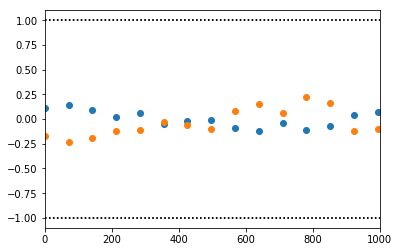

In [41]:
#model 2: both fix
plt.scatter(*z_fix['mu'].T)
plt.hlines([-1,1], 0, 1000, linestyles='dotted')
plt.xlim(0, 1000)
                  
plt.scatter(*z_fix['delta'].T)
plt.hlines([-1,1], 0, 1000, linestyles='dotted')
plt.xlim(0, 1000)



(0, 1000)

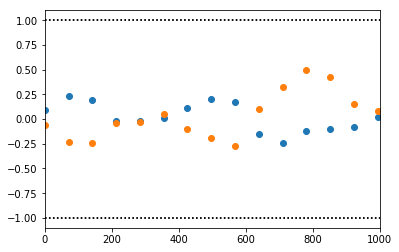

In [42]:
#model 3: random delta
plt.scatter(*z_rd['mu'].T)
plt.hlines([-1,1], 0, 1000, linestyles='dotted')
plt.xlim(0, 1000)
                  
plt.scatter(*z_rd['delta'].T)
plt.hlines([-1,1], 0, 1000, linestyles='dotted')
plt.xlim(0, 1000)



(0, 1000)

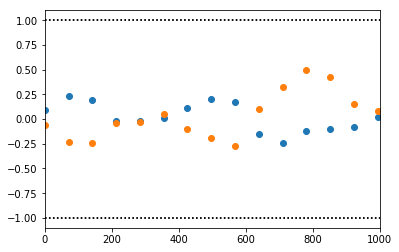

In [43]:
#model 4: both random
plt.scatter(*z_r['mu'].T)
plt.hlines([-1,1], 0, 1000, linestyles='dotted')
plt.xlim(0, 1000)
                  
plt.scatter(*z_r['delta'].T)
plt.hlines([-1,1], 0, 1000, linestyles='dotted')
plt.xlim(0, 1000)

For convergence diagnostic methods, I use the formal one proposed by Geweke (1992), is a time-series approach that compares the mean and variance of segments from the beginning and end of a single chain. From the 4 plots, I find model 2 (both mean and delta fixed) is the one most close to 0, so the segements from begining and end differ the least. Model 4 deviates from 0 a lot. 
Just based on closeness to 0, I will rank models for convergence:
model 2> model 1 > model 3 > model 4
In other words, the model with both mean and delta fixed converge the best, and the model with both mean and delta random converge the worst. This makes sense, since there are more certainty with fixed effects, so it's easier to converge.

#2. use posterior predictive checks to compare the fit of the models

In [44]:
from pymc3 import sample_ppc
with meta:
    sim_rm = sample_ppc(trace1,samples=500)

with metaf:
    sim_fix = sample_ppc(trace2,samples=500)
    
with metard:
    sim_rd = sample_ppc(trace3,samples=500)

with metar:
    sim_r = sample_ppc(trace4,samples=500)

100%|██████████| 500/500 [00:00<00:00, 954.12it/s]


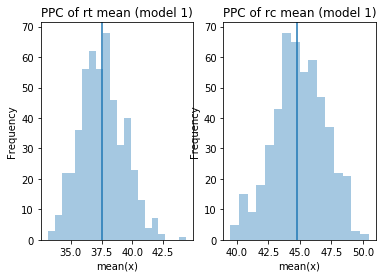

In [45]:
import seaborn as sns
#model 1: random mean
fig,ax=plt.subplots(1,2)
#obs_rt
#ax = plt.subplot()
sns.distplot([n.mean() for n in sim_rm['obs_rt']], kde=False, ax=ax[0])
ax[0].axvline( sum(r_t_obs)/len(r_t_obs) )
ax[0].set(title='PPC of rt mean (model 1)', xlabel='mean(x)', ylabel='Frequency');

sns.distplot([n.mean() for n in sim_rm['obs_rc']], kde=False, ax=ax[1])
ax[1].axvline( sum(r_c_obs)/len(r_c_obs) )
ax[1].set(title='PPC of rc mean (model 1)', xlabel='mean(x)', ylabel='Frequency');



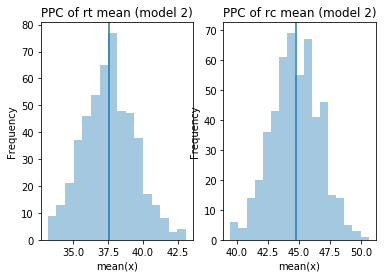

In [46]:

#model 2 both fix
fig,ax=plt.subplots(1,2)
#obs_rt
#ax = plt.subplot()
sns.distplot([n.mean() for n in sim_fix['obs_rt']], kde=False, ax=ax[0])
ax[0].axvline( sum(r_t_obs)/len(r_t_obs) )
ax[0].set(title='PPC of rt mean (model 2)', xlabel='mean(x)', ylabel='Frequency');

sns.distplot([n.mean() for n in sim_fix['obs_rc']], kde=False, ax=ax[1])
ax[1].axvline( sum(r_c_obs)/len(r_c_obs) )
ax[1].set(title='PPC of rc mean (model 2)', xlabel='mean(x)', ylabel='Frequency');


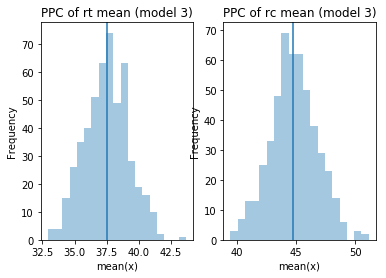

In [47]:
#model 3 random delta
fig,ax=plt.subplots(1,2)
#obs_rt
#ax = plt.subplot()
sns.distplot([n.mean() for n in sim_rd['obs_rt']], kde=False, ax=ax[0])
ax[0].axvline( sum(r_t_obs)/len(r_t_obs) )
ax[0].set(title='PPC of rt mean (model 3)', xlabel='mean(x)', ylabel='Frequency');

sns.distplot([n.mean() for n in sim_rd['obs_rc']], kde=False, ax=ax[1])
ax[1].axvline( sum(r_c_obs)/len(r_c_obs) )
ax[1].set(title='PPC of rc mean (model 3)', xlabel='mean(x)', ylabel='Frequency');


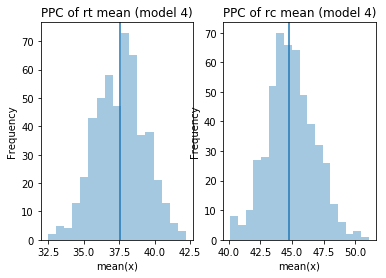

In [48]:
#model 4 both random
fig,ax=plt.subplots(1,2)
#obs_rt
#ax = plt.subplot()
sns.distplot([n.mean() for n in sim_r['obs_rt']], kde=False, ax=ax[0])
ax[0].axvline( sum(r_t_obs)/len(r_t_obs) )
ax[0].set(title='PPC of rt mean (model 4)', xlabel='mean(x)', ylabel='Frequency');

sns.distplot([n.mean() for n in sim_r['obs_rc']], kde=False, ax=ax[1])
ax[1].axvline( sum(r_c_obs)/len(r_c_obs) )
ax[1].set(title='PPC of rc mean (model 4)', xlabel='mean(x)', ylabel='Frequency');

Plotting the true mean (line) and sample means (histogram) can let us see how different the observed rt/rc is to predicted values. For rt mean, we see model 2 gives the most "concentrated" predictions (the highest freq is around 80%). The histogram for rc are similar.
Since if there is poor fit, the true value of the data may appear in the tails of the histogram of replicated data, while a good fit will tend to show the true data in high-probability regions of the posterior predictive distribution. We see all 4 models are doing relatively well: true mean in high probability regions.
Just based on visual inspection, I think model 2 fits the best, but can't tell the difference among model 1, 3 and 4.

#3. use DIC to compare the models as approximations of the true generating model

In [49]:
from pymc3 import dic

dic1=dic(trace1, meta)
dic2=dic(trace2,metaf)
dic3=dic(trace3,metard)
dic4=dic(trace4,metar)

In [51]:
dic1 #model 1

569.42143339681593

In [52]:
dic2 #model 2

557.64488951806925

In [53]:
dic3 #model 3

574.93916225976295

In [54]:
dic4 #model 4

585.95381663296939

To compare models using DIC, the idea is that models with smaller DIC should be preferred to models with large. We can see model 2 - both mean and delta fixed has the smallest DIC. 
Based on DIC value, I will rank models:
model 2> model 1> model 3> model 4

Combine convergence, PPC and DIC from question 1,2,3, it seems to me: model 2-fixed mean and delta is the best for the current task-make inferences about the population effect mean, and the predictive distribution for the effect  delta in a new trial. The reason be the data are small here, so the random models that allow more flexibility may not work for the problem here.